In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import numpy as np

In [2]:
qaoa_files = glob('*qaoa*.csv')
qaoa_files += glob('../02-09-2023/*qaoa*.csv')

In [3]:
print(qaoa_files)

['1_1_1_16_0_lightning_kokkos_qaoa_hypercube_maxcut_evolution.csv', '1_1_1_1_0_qiskit_aer_qaoa_hypercube_maxcut_evolution.csv', '3_1_1_64_0_lightning_kokkos_qaoa_hypercube_maxcut_evolution.csv', '2_1_1_128_0_lightning_kokkos_qaoa_hypercube_maxcut_evolution.csv', '2_1_1_64_0_lightning_qubit_qaoa_hypercube_maxcut_evolution.csv', '3_1_1_1_0_default_qubit_qaoa_hypercube_maxcut_evolution.csv', '1_1_1_64_0_lightning_qubit_qaoa_hypercube_maxcut_evolution.csv', '1_1_1_32_0_lightning_qubit_qaoa_hypercube_maxcut_evolution.csv', '1_1_1_128_0_lightning_qubit_qaoa_hypercube_maxcut_evolution.csv', '3_1_1_1_0_lightning_qubit_qaoa_hypercube_maxcut_evolution.csv', '2_1_1_64_0_lightning_kokkos_qaoa_hypercube_maxcut_evolution.csv', '2_1_1_1_0_qiskit_aer_qaoa_hypercube_maxcut_evolution.csv', '2_1_1_16_0_lightning_kokkos_qaoa_hypercube_maxcut_evolution.csv', '1_1_1_1_0_default_qubit_qaoa_hypercube_maxcut_evolution.csv', '2_1_1_32_0_lightning_qubit_qaoa_hypercube_maxcut_evolution.csv', '1_1_1_1_0_lightning_

In [5]:
qaoa_df = pd.concat([pd.read_csv(f) for f in qaoa_files])

/tmp/ipykernel_18628/4131817287.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  qaoa_df = pd.concat([pd.read_csv(f) for f in qaoa_files])


In [16]:
qaoa_df.head(1000)

,repeat,ansatz,backend,qubits,depth,n_expval,last_expval,func_time,circuit_time,wall_time,n_nodes,n_cpus,n_gpus
0,1,qaoa_hypercube_maxcut_evolution,lightning.kokkos (OpenMP),2,1,100,-0.464847,0.247884,0.246490,5.338266,1,16,0
1,1,qaoa_hypercube_maxcut_evolution,lightning.kokkos (OpenMP),2,2,100,-0.672076,0.285575,0.284279,2.183246,1,16,0
2,1,qaoa_hypercube_maxcut_evolution,lightning.kokkos (OpenMP),2,4,100,-0.527188,0.332945,0.331832,2.311026,1,16,0
3,1,qaoa_hypercube_maxcut_evolution,lightning.kokkos (OpenMP),2,8,100,-0.088610,0.524173,0.522886,1.736507,1,16,0
4,1,qaoa_hypercube_maxcut_evolution,lightning.kokkos (OpenMP),2,16,100,-0.906923,0.830226,0.829065,2.025828,1,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,1,qaoa_hypercube_maxcut_evolution,lightning.qubit,4,16,100,-0.906923,1.290590,1.288614,2.797544,1,128,0
17,1,qaoa_hypercube_maxcut_evolution,lightning.qubit,4,32,100,-0.383605,2.369750,2.367912,4.838959,1,128,0
18,1,qaoa_hypercube_maxcut_evolution,lightning.qubit,5,1,100,-0.464847,0.223426,0.221787,2.361871,1,128,0
19,1,qaoa_hypercube_maxcut_evolution,lightning.qubit,5,2,100,-0.672076,0.304106,0.302498,2.333580,1,128,0


In [9]:
new_df = qaoa_df.loc[qaoa_df['wall_time'] > 10]
new_df['qubits']

83    15
89    16
94    17
95    17
98    18
      ..
95    25
96    26
97    26
98    26
99    26
Name: qubits, Length: 2328, dtype: object

In [10]:
for backend in qaoa_df['backend'].unique():
    print(backend)

lightning.kokkos
lightning.qubit
default.qubit
qiskit.aer


In [11]:
qaoa_df.loc[qaoa_df.n_gpus ==1, ['backend']]= 'lightning.kokkos (HIP)'
qaoa_df.loc[qaoa_df.backend =='lightning.kokkos', ['backend']]= 'lightning.kokkos (OpenMP)'

In [14]:
qaoa_df.to_csv('test.csv')

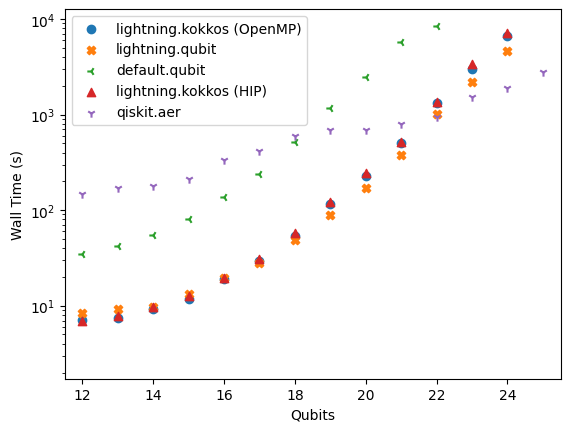

In [12]:
markers = ['o', 'X', '3', '^', '1']


for i, backend in enumerate(qaoa_df['backend'].unique()):
    if ((backend == 'lightning.qubit') or (backend == 'lightning.kokkos (OpenMP)')) or (backend == 'qiskit.aer'):
        backend_df = qaoa_df[qaoa_df['backend'] == backend]
        backend_df = backend_df[backend_df['n_cpus']==128]
    else:
        backend_df = qaoa_df[qaoa_df['backend'] == backend]
    depth_df = backend_df[backend_df['depth']==32]
    wall_time = depth_df.groupby(['qubits'])['wall_time'].mean()
    qubits = depth_df.groupby(['qubits'])['qubits'].mean()
    #print(m)
    #print(wall_time)
    plt.scatter(qubits, wall_time, marker = markers[i], label = backend, color = f'C{i}')

plt.yscale('log')
plt.xlim(11.5,  25.5)
plt.xlabel('Qubits')
plt.ylabel('Wall Time (s)')
plt.xticks([i for i in range(12, 25, 2)])
plt.legend()
plt.show()

1
21
21
21
qubits
11    11.0
12    12.0
13    13.0
14    14.0
15    15.0
16    16.0
17    17.0
18    18.0
19    19.0
20    20.0
21    21.0
22    22.0
Name: qubits, dtype: object qubits
10    10.0
11    11.0
12    12.0
13    13.0
14    14.0
15    15.0
16    16.0
17    17.0
18    18.0
19    19.0
20    20.0
21    21.0
22    22.0
Name: qubits, dtype: object


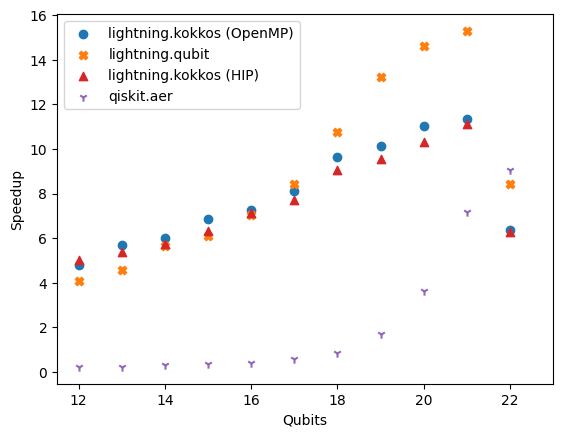

In [107]:
markers = ['o', 'X', '*', '^', '1']

lightning_kokkos_openmp = qaoa_df[qaoa_df['backend']=='default.qubit']

s_depth_df = lightning_kokkos_openmp[lightning_kokkos_openmp['depth'] == 32]
s_cpus_df = s_depth_df[s_depth_df['n_cpus'] == 1]
s_wall_time = s_cpus_df.groupby(['qubits'])['wall_time'].mean()
s_qubits = s_cpus_df.groupby(['qubits'])['qubits'].mean()

for i, backend in enumerate(qaoa_df['backend'].unique()):
    if backend == "default.qubit":
        continue
    if ((backend == 'lightning.qubit') or (backend == 'lightning.kokkos (OpenMP)')) or (backend == 'qiskit.aer'):
        backend_df = qaoa_df[qaoa_df['backend'] == backend]
        backend_df = backend_df[backend_df['n_cpus']==128]
    else:
        backend_df = qaoa_df[qaoa_df['backend'] == backend]
    depth_df = backend_df[backend_df['depth']==32]
    wall_time = depth_df.groupby(['qubits'])['wall_time'].mean()
    qubits = depth_df.groupby(['qubits'])['qubits'].mean()
    print(m)
    #print(s_qubits, qubits, wall_time, s_wall_time)
    if not backend == 'qiskit.aer':
        m = np.min([len(s_qubits), len(qubits), len(wall_time)])
        plt.scatter(qubits[:m], s_wall_time[:m]/wall_time[:m], marker = markers[i], label = backend, color = f'C{i}')
    else:
        print(s_qubits[9:], qubits[:13])
        plt.scatter(qubits[:13], s_wall_time[10:23]/wall_time[:13], marker = markers[i], label = backend, color = f'C{i}')

#plt.yscale('log')
plt.xlim(11.5,  23)
plt.legend()
plt.xlabel('Qubits')
plt.ylabel('Speedup')
plt.show()

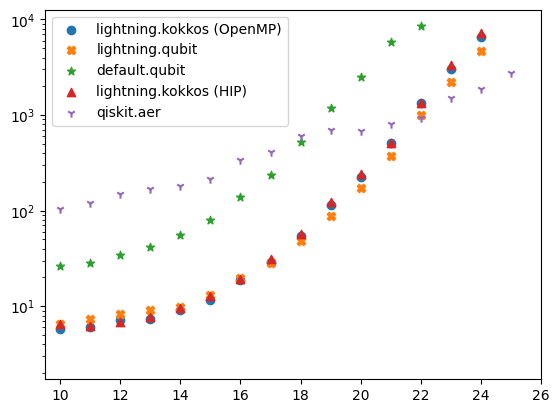

In [108]:
markers = ['o', 'X', '*', '^', '1']
for i, backend in enumerate(qaoa_df['backend'].unique()):
    if ((backend == 'lightning.qubit') or (backend == 'lightning.kokkos (OpenMP)')) or (backend == 'qiskit.aer'):
        backend_df = qaoa_df[qaoa_df['backend'] == backend]
        backend_df = backend_df[backend_df['n_cpus']==128]
    else:
        backend_df = qaoa_df[qaoa_df['backend'] == backend]
    depth_df = backend_df[backend_df['depth']==32]
    wall_time = depth_df.groupby(['qubits'])['wall_time'].mean()
    qubits = depth_df.groupby(['qubits'])['qubits'].mean()
    plt.scatter(qubits, wall_time, marker = markers[i], label = backend, color = f'C{i}')
plt.yscale('log')
plt.xlim(9.5,  26)
plt.legend()
plt.show()

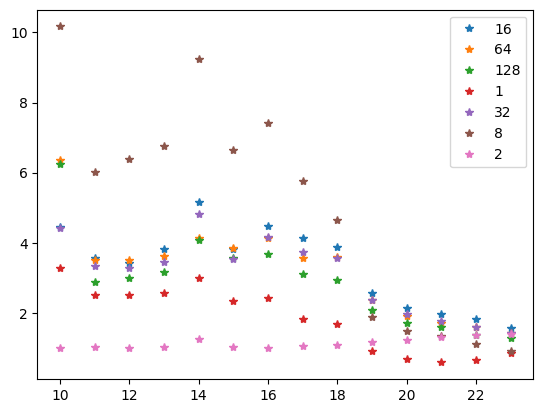

In [109]:
lightning_kokkos_openmp = qaoa_df[qaoa_df['backend']=='qiskit.aer']

s_depth_df = lightning_kokkos_openmp[lightning_kokkos_openmp['depth'] == 1]
s_cpus_df = s_depth_df[s_depth_df['n_cpus'] == 1]
s_wall_time = s_cpus_df.groupby(['qubits'])['wall_time'].mean()
s_qubits = s_cpus_df.groupby(['qubits'])['qubits'].mean()

for i, cpus in enumerate(qaoa_df['n_cpus'].unique()):
    depth_df = qaoa_df[qaoa_df['depth'] == 1]
    cpus_df = depth_df[depth_df['n_cpus'] == cpus]
    wall_time = cpus_df.groupby(['qubits'])['wall_time'].mean()
    qubits = cpus_df.groupby(['qubits'])['qubits'].mean()
    #print(s_wall_time/wall_time)
    m = max(len(s_qubits), len(qubits))
    if len(qubits) > 0:
        plt.plot(qubits,s_wall_time[:m]/wall_time[:m], '*', label = cpus)
plt.legend()
plt.show()

qubits
2       1.984659
3       2.515609
4       2.552735
5       2.068620
6       2.241851
7       2.490633
8       2.478899
9       2.769111
10      3.451880
11      2.922543
12      3.341566
13      3.589696
14      4.322555
15      5.462327
16      8.929019
17     15.330801
18     29.309174
19     64.447958
20    139.628154
21    297.479849
22    647.931144
Name: wall_time, dtype: float64
21
21
21
21
18


ValueError: x and y must have same first dimension, but have shapes (18,) and (26,)

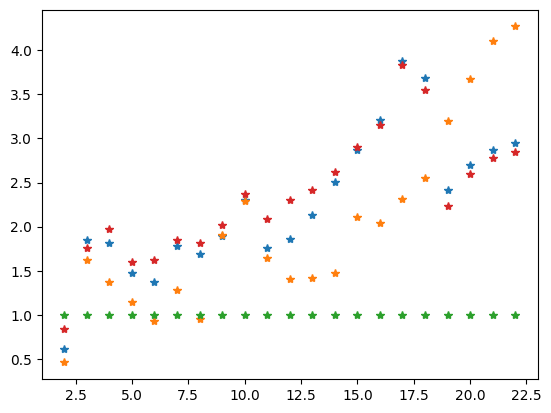

In [110]:
default_df = qaoa_df[qaoa_df['backend']=='default.qubit']
base_df = default_df[default_df['depth'] == 1]
s_cpus_df = base_df[base_df['n_cpus'] == 1]
s_wall_time = s_cpus_df.groupby(['qubits'])['wall_time'].mean()
s_qubits = s_cpus_df.groupby(['qubits'])['qubits'].mean()

print(s_wall_time)
for i, backend in enumerate(qaoa_df['backend'].unique()):
    if (backend == 'lightning.qubit') or (backend == 'lightning.kokkos (OpenMP)'):
        backend_df = qaoa_df[qaoa_df['backend'] == backend]
        backend_df = backend_df[backend_df['n_cpus']==128]
    else:
        backend_df = qaoa_df[qaoa_df['backend'] == backend]
    depth_df = backend_df[backend_df['depth']==1]
    wall_time = depth_df.groupby(['qubits'])['wall_time'].mean()
    qubits = depth_df.groupby(['qubits'])['qubits'].mean()
    m = min([len(s_wall_time), len(wall_time), len(qubits)])
    print(len(wall_time[:m]))
    plt.plot(qubits[:m], s_wall_time[:m]/wall_time[:m], '*', label = backend, color = f'C{i}')
plt.legend()
plt.show()

In [ ]:
s_wall_time

In [ ]:
for i, backend in enumerate(qaoa_df['backend'].unique()):
    if (backend == 'lightning.qubit') or (backend == 'lightning.kokkos (OpenMP)'):
        backend_df = qaoa_df[qaoa_df['backend'] == backend]
        backend_df = backend_df[backend_df['n_cpus']==128]
    else:
        backend_df = qaoa_df[qaoa_df['backend'] == backend]
    depth_df = backend_df[backend_df['qubits']==20]
    wall_time = depth_df.groupby(['depth'])['wall_time'].mean()
    qubits = depth_df.groupby(['depth'])['depth'].mean()
    print(qubits)
    plt.plot(qubits, wall_time, '*', label = backend, color = f'C{i}')
#plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
default_df = qaoa_df[qaoa_df['backend']=='default.qubit']
base_df = default_df[default_df['qubits'] == 20]
s_cpus_df = base_df[base_df['n_cpus'] == 1]
s_wall_time = s_cpus_df.groupby(['depth'])['wall_time'].mean()
s_qubits = s_cpus_df.groupby(['depth'])['depth'].mean()

print(s_wall_time)
for i, backend in enumerate(qaoa_df['backend'].unique()):
    if (backend == 'lightning.qubit') or (backend == 'lightning.kokkos (OpenMP)'):
        backend_df = qaoa_df[qaoa_df['backend'] == backend]
        backend_df = backend_df[backend_df['n_cpus']==128]
    else:
        backend_df = qaoa_df[qaoa_df['backend'] == backend]
    depth_df = backend_df[backend_df['qubits']==20]
    wall_time = depth_df.groupby(['depth'])['wall_time'].mean()
    qubits = depth_df.groupby(['depth'])['depth'].mean()
    m = min([len(s_wall_time), len(wall_time), len(qubits)])
    print(len(wall_time[:m]))
    plt.plot(qubits[:m], s_wall_time[:m]/wall_time[:m], '*', label = backend, color = f'C{i}')
plt.legend()
plt.show()